In [1]:
from graph import *
from models import *

In [2]:
import pandas as pd

In [3]:
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import plotly.graph_objects as go

In [4]:
scaling = pd.read_excel("wall time scaling.xlsx", sheet_name="Data")

In [5]:
fit_poly = lambda x, k3, k2, k1: k3 * x ** 3 + k2 * x ** 2 + k1 * x
k, cv = curve_fit(fit_poly, scaling["Size"], scaling["Wall Time"])
k_gpu, cv_gpu = curve_fit(fit_poly, scaling["Size"], scaling["Wall Time GPU"])

In [6]:
funcs = {"Global": lambda x: fit_poly(x, *k), "Intermediate": lambda x: x / 2.0e6}
funcs_gpu = {"Global": lambda x: fit_poly(x, *k_gpu), "Intermediate": lambda x: x / 2.0e6}

In [7]:
detectors, triggers, globals = dataframes_from_spreadsheet("cms_system_60.xlsx")

In [8]:
triggers.iloc[4]["Reduction Ratio"]

400

In [9]:
cms_run5  = construct_graph(detectors, triggers, globals, funcs)

In [10]:
cms_run5

In [11]:
cms_run5.nodes["Intermediate"]["classifier"].reduction

0.9975

In [12]:
cms_run5.nodes["Intermediate"]["classifier"].error_matrix

array([[0.99751433, 0.42421788],
       [0.00248567, 0.57578212]])

In [13]:
cms_run5.nodes["Intermediate"]["contingency"]

array([[3.98995758e+07, 4.24217879e+02],
       [9.94242136e+04, 5.75782121e+02]])

In [14]:
cms_run5.graph["op power"] / 1e6 / density_scale_model(2032)

0.3174774810934562

In [15]:
total_reduction = 40e6 / 7.5e3

In [16]:
triggers

,Name,Output,Data (bytes),Reduction Ratio,Skill mean,Skill variance,Link Efficiency (J/bit),Op Efficiency (J/op),Compression
0,Tracking,Intermediate,0,1,0,1,2.500000e-11,0.000,0
1,Timing,Intermediate,0,1,0,1,2.500000e-11,0.000,0
2,Calorimetry,Intermediate,0,1,0,1,2.500000e-11,0.000,0
3,Muon,Intermediate,0,1,0,1,2.500000e-11,0.000,0
4,Intermediate,Global,260000,400,3,1,2.500000e-11,0.003,0
5,Global,Disk,0,100,4,1,2.500000e-11,16.000,0
6,Disk,NaN,0,1,0,1,2.500000e-11,0.000,0


In [17]:
total_reduction

5333.333333333333

In [18]:
from metrics import *

In [51]:
def vary_l1t_accept(reduction: float):
    t = triggers.copy()
    #intermediate reduction stage
    t.at[4, "Reduction Ratio"] = reduction
    #global reduction stage
    t.at[5, "Reduction Ratio"] = total_reduction / reduction
    g = construct_graph(detectors, t, globals, funcs)

    power = g.graph["op power"] + g.graph["link power"]
    p = g.graph["performance"]
    a = precision(p)
    r = recall(p)
    f1 = f1_score(p)
    #return g

    return (p, a, r, f1), power

In [52]:
g3 = vary_l1t_accept(53.3)

In [53]:
g3[0]

(array([[3.99904696e+07, 2.03038895e+03],
        [2.03038909e+03, 5.46961105e+03]]),
 0.729281460149761,
 0.7292814732276702,
 0.7292814666887156)

In [54]:
l1t_reductions = np.linspace(400, 50.0, 101)

In [55]:
l1t_reductions

array([400. , 396.5, 393. , 389.5, 386. , 382.5, 379. , 375.5, 372. ,
       368.5, 365. , 361.5, 358. , 354.5, 351. , 347.5, 344. , 340.5,
       337. , 333.5, 330. , 326.5, 323. , 319.5, 316. , 312.5, 309. ,
       305.5, 302. , 298.5, 295. , 291.5, 288. , 284.5, 281. , 277.5,
       274. , 270.5, 267. , 263.5, 260. , 256.5, 253. , 249.5, 246. ,
       242.5, 239. , 235.5, 232. , 228.5, 225. , 221.5, 218. , 214.5,
       211. , 207.5, 204. , 200.5, 197. , 193.5, 190. , 186.5, 183. ,
       179.5, 176. , 172.5, 169. , 165.5, 162. , 158.5, 155. , 151.5,
       148. , 144.5, 141. , 137.5, 134. , 130.5, 127. , 123.5, 120. ,
       116.5, 113. , 109.5, 106. , 102.5,  99. ,  95.5,  92. ,  88.5,
        85. ,  81.5,  78. ,  74.5,  71. ,  67.5,  64. ,  60.5,  57. ,
        53.5,  50. ])

In [56]:
res = [vary_l1t_accept(r) for r in l1t_reductions]

In [57]:
all_power = [r[1] for r in res]

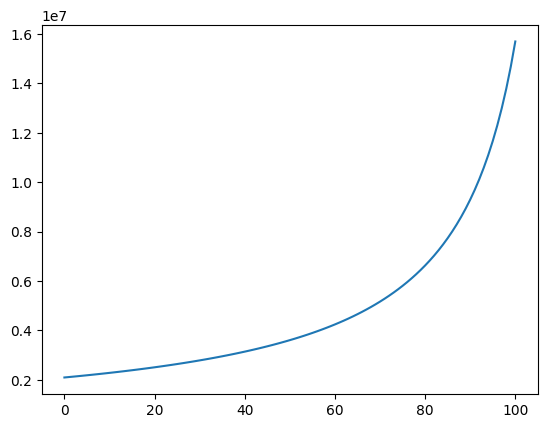

In [58]:
plt.plot(all_power)

In [59]:
c = np.stack([r[0][0] for r in res])

In [60]:
c[0]

array([[3.99892197e+07, 3.28027241e+03],
       [3.28027256e+03, 4.21972759e+03]])

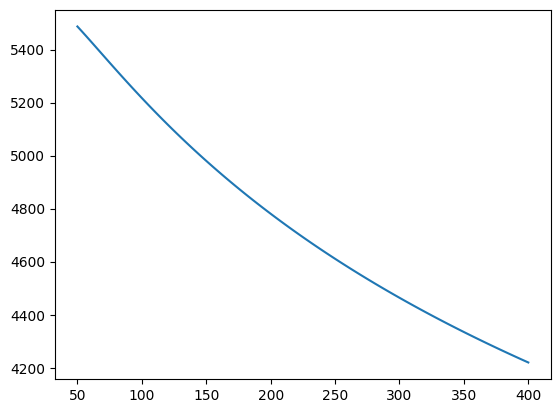

In [61]:
plt.plot(l1t_reductions, [x[1,1] for x in c], label="TP")

In [62]:
l1t_reductions[np.argmax([x[0,0] for x in c])]

50.0

In [63]:
5333.3 / 24.0

222.22083333333333

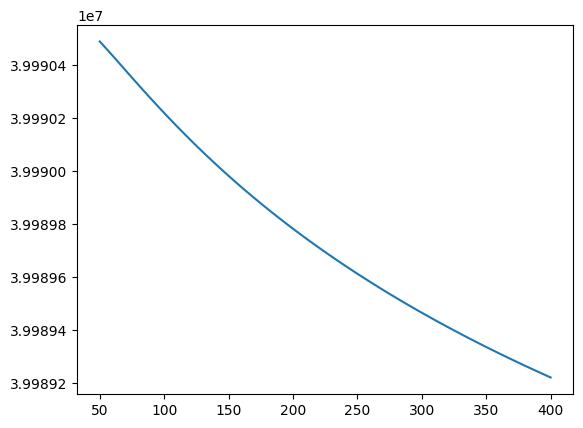

In [64]:
plt.plot(l1t_reductions, [x[0,0] for x in c], label="TN")

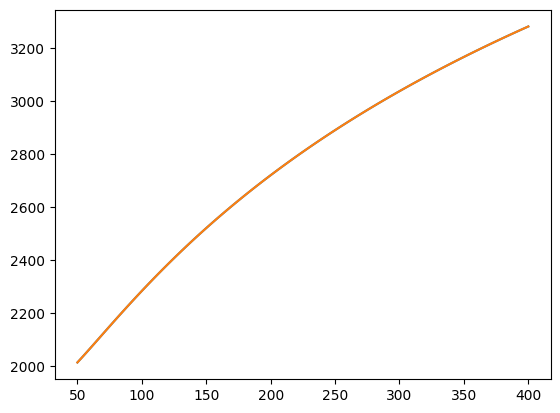

In [65]:
plt.plot(l1t_reductions, [x[1,0] for x in c], label="FP")
plt.plot(l1t_reductions, [x[0,1] for x in c], label="FN")

In [66]:
np.sum(c, axis=(1,2))

array([40000000.        , 40000000.        , 40000000.        ,
       40000000.00000001, 39999999.99999999, 40000000.        ,
       40000000.        , 39999999.99999999, 40000000.00000001,
       40000000.        , 40000000.00000001, 40000000.00000001,
       40000000.        , 40000000.00000001, 40000000.        ,
       40000000.        , 40000000.        , 40000000.        ,
       40000000.        , 40000000.        , 40000000.        ,
       40000000.        , 40000000.        , 40000000.        ,
       40000000.        , 40000000.        , 40000000.        ,
       39999999.99999999, 40000000.        , 40000000.        ,
       40000000.00000001, 39999999.99999999, 40000000.        ,
       40000000.        , 40000000.        , 40000000.        ,
       40000000.        , 40000000.00000001, 40000000.        ,
       40000000.        , 39999999.99999999, 39999999.99999999,
       39999999.99999999, 40000000.        , 40000000.        ,
       40000000.        , 40000000.     

In [67]:
[np.sum(x[1,:]) for x in c]

[7500.00015358387,
 7500.000105470921,
 7499.999823418791,
 7499.999882482499,
 7500.000551678427,
 7499.999570847531,
 7499.999858592933,
 7500.00010486807,
 7500.000196002849,
 7499.999598109889,
 7500.00029755819,
 7500.000455732616,
 7500.000137714719,
 7500.00049431075,
 7499.999731191883,
 7499.999572613335,
 7500.00024070216,
 7499.999481932976,
 7499.999959933945,
 7500.0004217324695,
 7499.999868267961,
 7499.999762279354,
 7499.999566142396,
 7499.999805194289,
 7500.000006522161,
 7500.000240625993,
 7499.999732122549,
 7499.999693404339,
 7500.000460315805,
 7500.000391443754,
 7500.000423179279,
 7499.999614579954,
 7499.999469383858,
 7500.000387229145,
 7499.999537068218,
 7499.9993849708535,
 7500.000082714843,
 7500.000514471611,
 7499.999805922474,
 7500.000179541436,
 7500.00060999109,
 7500.000090724106,
 7499.999641313929,
 7500.0001202892945,
 7499.999672393752,
 7499.999560886092,
 7500.000141665922,
 7499.99966858916,
 7499.999732193626,
 7499.999990795462,
 749

In [68]:
c.shape

(101, 2, 2)

In [69]:
c[0]

array([[3.99892197e+07, 3.28027241e+03],
       [3.28027256e+03, 4.21972759e+03]])

In [70]:
c[50]

array([[3.99896926e+07, 2.80739315e+03],
       [2.80739312e+03, 4.69260685e+03]])

In [74]:
res2 = np.stack([r[0][2] for r in res])

In [75]:
res2.shape

(101,)

Text(0.5, 0, 'DAQ Power')

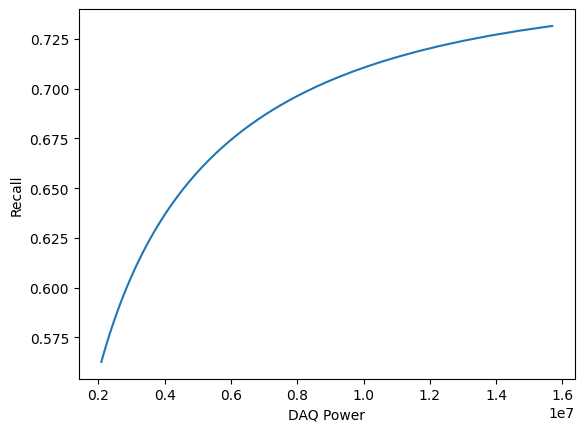

In [78]:
#plt.plot(res2[:,0], res2[:,1], label = "Precision")
plt.plot(all_power, res2, label = "Recall")
#plt.plot(res2[:,0], res2[:,3], label = "F1")
plt.ylabel("Recall")
plt.xlabel("DAQ Power")